In [14]:
import numpy
import tokenization
from tokenization import tokenize_word
import tensorflow as tf
import numpy as np
from data_collection import collect_conversation
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import data_collection
import tokenization
import train_model
from train_model import plot_model_accurate

In [15]:
# Preprocessing
text_generation_dataset = collect_conversation()    # collect dataset
dataset_for_hotel = text_generation_dataset[0]
dataset_for_restaurant = text_generation_dataset[1]

# data collect and setting part
# label the message need to response or not
# if system response is '', then the label will be 0 (means no need to response)
user_input_message, system_output_message = [], []
user_input_response_label, turn_stage_with_messages = [], []
for conversation in dataset_for_hotel:
    user_input_message.append(conversation['hotel_user_transcript'])
    system_output_message.append(conversation['hotel_system_transcript'])
    turn_stage_with_messages.append({"turn_id": conversation['hotel_turn_id'],
                                     "user_input": conversation['hotel_user_transcript'],
                                     "system_output": conversation['hotel_system_transcript']
                                     })
    if conversation['hotel_system_transcript'] == '':
        user_input_response_label.append(0)     # 0 means no need to response
    else:
        user_input_response_label.append(1)     # 1 means need to response
for conversation in dataset_for_restaurant:
    user_input_message.append(conversation['restaurant_user_transcript'])
    system_output_message.append(conversation['restaurant_system_transcript'])
    turn_stage_with_messages.append({"turn_id": conversation['restaurant_turn_id'],
                                     "user_input": conversation['restaurant_user_transcript'],
                                     "system_output": conversation['restaurant_system_transcript']
                                     })
    if conversation['restaurant_system_transcript'] == '':
        user_input_response_label.append(0)     # 0 means no need to response
    else:
        user_input_response_label.append(1)     # 1 means need to response


# split data for train and test (train response or not)
user_input_response_train = user_input_message[:8000]
user_input_response_train_label = user_input_response_label[:8000]
user_input_response_test = user_input_message[8000:]
user_input_response_test_label = user_input_response_label[8000:]

# Dictionary    !!! Tokenizer !!!
tokenizer_for_response, padded_tokenized_user_response_train, padded_tokenized_user_response_test \
    = tokenization.tokenize_message(user_input_response_train, user_input_response_test)
# train model
response_train = [padded_tokenized_user_response_train, user_input_response_train_label]
response_test = [padded_tokenized_user_response_test, user_input_response_test_label]
# train_model.train_response_or_not_models(tokenizer_for_response, response_train, response_test)


# stage check model (using functional structure)
stage_user_message, stage_system_message, stage_label = [], [], []
for turn in turn_stage_with_messages:
    stage_user_message.append(turn['user_input'])
    stage_system_message.append(turn['system_output'])
    if turn['turn_id'] == 0:
        turn_stage_label = [1, 0, 0]
    elif turn['system_output'] == '':
        turn_stage_label = [0, 0, 1]
    else:
        turn_stage_label = [0, 1, 0]
    stage_label.append(turn_stage_label)

user_input_stage_train = stage_user_message[:8000]
user_input_stage_train_label = stage_label[:8000]
user_input_stage_test = stage_user_message[8000:]
user_input_stage_test_label = stage_label[8000:]

# add 'start=(index3)' and 'end'=(index2) in the corresponding position
stage_system_message_with_tag = []
for sentence in stage_system_message:
    if sentence != '':
        stage_system_message_with_tag.append('start ' + sentence + ' end') # no /start, /end since not in all sentence
system_input_stage_train = stage_system_message_with_tag[:6000]
system_input_stage_test = stage_system_message_with_tag[6000:]

In [16]:
# 2 Dictionary
# user dictionary
tokenizer_for_stage_for_user, padded_tokenized_user_stage_train, padded_tokenized_user_stage_test \
    = tokenization.tokenize_message(user_input_stage_train, user_input_stage_test)
tokenizer_for_stage_for_system, padded_tokenized_system_stage_train, padded_tokenized_system_stage_test \
    = tokenization.tokenize_message_for_response(system_input_stage_train, system_input_stage_test)

# # train model stage   (check message need to response or not)
# stage_train = [padded_tokenized_user_stage_train, user_input_stage_train_label, user_input_response_train_label]
# stage_test = [padded_tokenized_user_stage_test, user_input_stage_test_label, user_input_response_test_label]
# train_model.message_stage_model(tokenizer_for_stage_for_user, stage_train, stage_test)

# train response model
# for system
all_sentence_predict_pair, user_input_index = [], 0
for sentence in system_input_stage_train:
    all_round_message, previous_message = [], ''
    sentence_in_list = sentence.split()
    for word in sentence_in_list:
        if word == 0:
            break
        tokenized_transcript = tokenizer_for_stage_for_system.texts_to_sequences([previous_message])
        tokenized_transcript_word = tokenizer_for_stage_for_system.texts_to_sequences([word])
        padded_tokenized_transcript = pad_sequences(tokenized_transcript, maxlen=35, padding='post', truncating='post')
        padded_tokenized_keyword = pad_sequences(tokenized_transcript_word, maxlen=1, padding='post', truncating='post')
        all_round_message.append({'user_input': padded_tokenized_user_stage_train[user_input_index],
                                  'message': padded_tokenized_transcript[0], 'predict_word': tokenization.one_hot(padded_tokenized_keyword[0])})
        previous_message = previous_message + word + ' '
    user_input_index += 1
    all_sentence_predict_pair.append(all_round_message)
user_input_index = 0
for sentence in system_input_stage_test:
    all_round_message, previous_message = [], ''
    sentence_in_list = sentence.split()
    for word in sentence_in_list:
        if word == 0:
            break
        tokenized_transcript = tokenizer_for_stage_for_system.texts_to_sequences([previous_message])
        tokenized_transcript_word = tokenizer_for_stage_for_system.texts_to_sequences([word])
        padded_tokenized_transcript = pad_sequences(tokenized_transcript, maxlen=35, padding='post', truncating='post')
        padded_tokenized_keyword = pad_sequences(tokenized_transcript_word, maxlen=1, padding='post', truncating='post')
        all_round_message.append({'user_input': padded_tokenized_user_stage_test[user_input_index],
                                  'message': padded_tokenized_transcript[0], 'predict_word': tokenization.one_hot(padded_tokenized_keyword[0])})
        previous_message = previous_message + word + ' '
    all_sentence_predict_pair.append(all_round_message)
print(len(all_sentence_predict_pair))

6840


In [17]:
# collect all pair as array
data_dic_train = all_sentence_predict_pair[:5000]
data_dic_test = all_sentence_predict_pair[5000:]
user_input_pair_train, system_message_train, predict_word_train = [], [], []
for sentence in data_dic_train:
    for turn in sentence:
        user_input_pair_train.append(turn['user_input'])
        system_message_train.append(turn['message'])
        predict_word_train.append(turn['predict_word'])
user_input_pair_test, system_message_test, predict_word_test = [], [], []
for sentence in data_dic_test:
    for turn in sentence:
        user_input_pair_test.append(turn['user_input'])
        system_message_test.append(turn['message'])
        predict_word_test.append(turn['predict_word'])

In [18]:
# train model
# size: user_input = 25, generated_input = 35, output_probobility = 2514
print("Train message generate model")
user_message_input = tf.keras.Input(shape=(25,), name="user_input")
system_accrue_message_input = tf.keras.Input(shape=(35,), name="system_accrue_message_input")
user_message_features = tf.keras.layers.Embedding(25+1, 32)(user_message_input)
system_message_features = tf.keras.layers.Embedding(35+1, 64)(system_accrue_message_input)

user_message_features = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(user_message_features)
system_message_features = tf.keras.layers.LSTM(512)(system_message_features)
combine_layer = tf.keras.layers.concatenate([user_message_features, system_message_features])
control_range_layer = tf.keras.layers.Dense(256, activation='linear')(combine_layer)
control_range_layer = tf.keras.layers.Dense(128, activation='relu')(control_range_layer)
predict_output = tf.keras.layers.Dense(600, name="predict_output", activation='sigmoid')(control_range_layer)
response_model = tf.keras.Model(inputs=[user_message_input, system_accrue_message_input],
                                outputs=[predict_output], )
response_model.compile(loss=['binary_crossentropy'], optimizer='adam', metrics=['acc'])
print(response_model.summary())
# tf.keras.utils.plot_model(response_model, 'stage_model.png', show_shapes=True)

Train message generate model
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 25)]         0           []                               
                                                                                                  
 system_accrue_message_input (I  [(None, 35)]        0           []                               
 nputLayer)                                                                                       
                                                                                                  
 embedding_6 (Embedding)        (None, 25, 32)       832         ['user_input[0][0]']             
                                                                                                  
 embedding_7 (Embedding)        (None, 35, 64)       2304      

Epoch 1/10


2022-04-09 08:36:22.699490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-09 08:36:23.058447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-09 08:36:23.058496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-09 08:36:23.069444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-09 08:36:23.247626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-09 08:36:23.262904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-04-09 08:36:23.279114: I tensorflow/core/grappler/optimizers/cust

2908/2908 - 113s - loss: 0.0125 - acc: 0.0488 - val_loss: 0.0101 - val_acc: 0.0539 - 113s/epoch - 39ms/step
Epoch 2/10
2908/2908 - 111s - loss: 0.0101 - acc: 0.0504 - val_loss: 0.0100 - val_acc: 0.0539 - 111s/epoch - 38ms/step
Epoch 3/10
2908/2908 - 112s - loss: 0.0100 - acc: 0.0515 - val_loss: 0.0099 - val_acc: 0.0540 - 112s/epoch - 38ms/step
Epoch 4/10
2908/2908 - 112s - loss: 0.0097 - acc: 0.0964 - val_loss: 0.0095 - val_acc: 0.1078 - 112s/epoch - 39ms/step
Epoch 5/10
2908/2908 - 112s - loss: 0.0095 - acc: 0.1042 - val_loss: 0.0095 - val_acc: 0.1078 - 112s/epoch - 38ms/step
Epoch 6/10
2908/2908 - 110s - loss: 0.0095 - acc: 0.1053 - val_loss: 0.0095 - val_acc: 0.1078 - 110s/epoch - 38ms/step
Epoch 7/10
2908/2908 - 112s - loss: 0.0095 - acc: 0.1055 - val_loss: 0.0095 - val_acc: 0.1078 - 112s/epoch - 39ms/step
Epoch 8/10
2908/2908 - 112s - loss: 0.0092 - acc: 0.1214 - val_loss: 0.0088 - val_acc: 0.1484 - 112s/epoch - 39ms/step
Epoch 9/10
2908/2908 - 112s - loss: 0.0084 - acc: 0.1868 - 

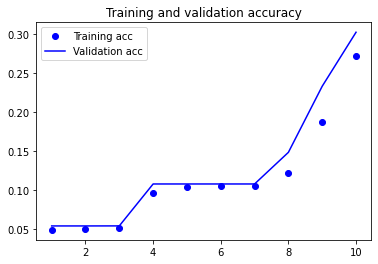

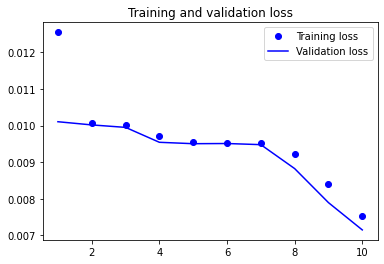

In [19]:
#
# # problem start at here
history = response_model.fit({"user_input": np.array(user_input_pair_train), "system_accrue_message_input": np.array(system_message_train)},
                             np.array(predict_word_train), epochs=10,
                             validation_data=({"user_input": np.array(user_input_pair_test), "system_accrue_message_input": np.array(system_message_test)},
                                       np.array(predict_word_test)), verbose=2)
plot_model_accurate(history)    # plot graph
response_model.save('system_response.h5')

In [63]:
# test the model
user_input = ["am looking for a place to to stay that has cheap price range it should be in a type of hotel"
              ,'Thanks'
              ,"no, i just need to make sure it's cheap. oh, and i need parking"
              ,"yes, please. 6 people 3 nights starting on tuesday."
              ]
user_input_sentence = tokenizer_for_stage_for_user.texts_to_sequences(user_input)
system_output = [''
                 ,'start i have have restaurants restaurants restaurants is town is there anything else'
                 ,"i found 1 cheap hotel for you that includes"
                 ,"i am sorry but i wasn't able to book that for you for"
                 ]
system_output_sentence = tokenizer_for_stage_for_system.texts_to_sequences(system_output)

In [64]:
# input layer data text
padded_user_input = pad_sequences(user_input_sentence, maxlen=25, padding='post', truncating='post')
padded_predicted_sentence = pad_sequences(system_output_sentence, maxlen=35, padding='post', truncating='post')
all_prediction = response_model.predict({"user_input": padded_user_input, "system_accrue_message_input": padded_predicted_sentence})

print(len(all_prediction))
for predict in all_prediction:
    print(max(predict))
    for index in range(len(predict)):
        if predict[index] == max(predict):
            print(index)
    print()


4
0.9999136
3

0.9936199
24

0.054401338
6

0.2270182
4



In [22]:
print(tokenizer_for_stage_for_system.word_index)

{'<OOV>': 1, 'end': 2, 'start': 3, 'you': 4, 'the': 5, 'is': 6, 'i': 7, 'in': 8, 'a': 9, 'and': 10, 'would': 11, 'there': 12, 'to': 13, 'for': 14, 'like': 15, 'of': 16, 'are': 17, 'number': 18, 'have': 19, 'that': 20, 'can': 21, 'your': 22, 'restaurant': 23, 'else': 24, 'at': 25, 'with': 26, 'town': 27, 'anything': 28, 'price': 29, 'range': 30, 'do': 31, 'food': 32, 'book': 33, 'centre': 34, 'reference': 35, 'help': 36, 'it': 37, 'restaurants': 38, 'hotel': 39, 'or': 40, 'phone': 41, 'area': 42, 'was': 43, 'me': 44, 'located': 45, 'part': 46, 'expensive': 47, 'sorry': 48, 'what': 49, 'house': 50, 'no': 51, 'city': 52, 'cheap': 53, 'one': 54, 'booking': 55, '01223': 56, 'road': 57, 'address': 58, 'their': 59, 'on': 60, 'north': 61, 'be': 62, 'another': 63, 'try': 64, 'yes': 65, 'how': 66, 'free': 67, "i'm": 68, 'any': 69, 'star': 70, '4': 71, 'parking': 72, 'reservation': 73, 'moderate': 74, 'different': 75, 'serves': 76, 'type': 77, 'stay': 78, 'booked': 79, 'they': 80, 'guesthouse': 8